In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson2D
problem = Poisson2D()

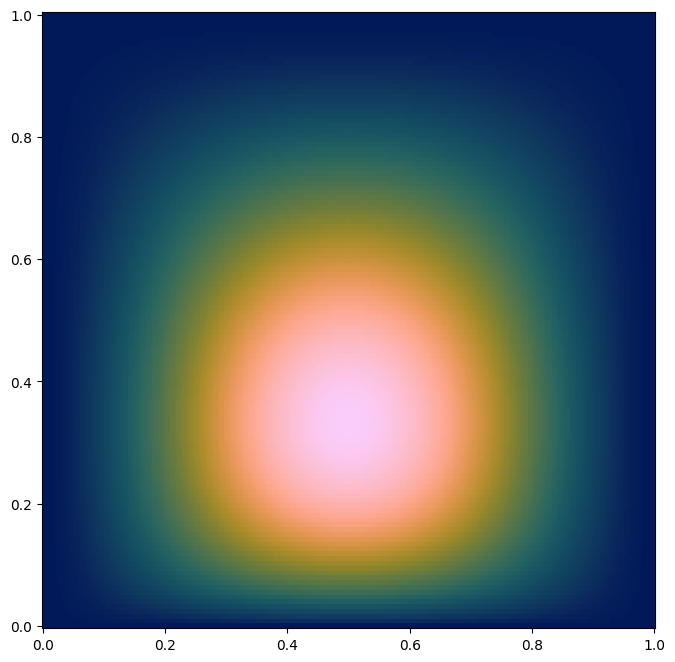

In [3]:
X, Y, u_solution = problem.exact_solution(nx=256, ny=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, Y, u_solution, cmap=cmap)

# Optimiser

In [4]:
class GeneralisedLevenbergMarquardt:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 1.5,
        increase_factor: float = 1.5,
        used_factor: float = 1.0,
        max_trials: int = 10,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.used_factor = used_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        n_params = len(params_flat)

        # 1. ONE-TIME EXPENSIVE STEP: Perform QR factorization on the Jacobian
        J = jax.jacfwd(flat_residual_fn)(params_flat)
        Q, R = jnp.linalg.qr(J, mode='reduced')

        # 2. ONE-TIME CALCULATION: Compute the part of the RHS that doesn't change
        # This is the equivalent of d = -Q^T * r
        rhs_top = -Q.T @ residuals

        def evaluate_trial_step(loop_val):
            # Unpack the loop state
            trial_lambda, _, trial_count, _ = loop_val
            
            # 3. FAST UPDATE STEP (for each lambda)
            # Form the small, temporary augmented system: [R; sqrt(λ)I] Δx ≈ [d; 0]
            
            # Form the augmented matrix A_aug = [R; sqrt(λ)I]
            aug_matrix = jnp.vstack([
                R,
                jnp.sqrt(trial_lambda) * jnp.eye(n_params)
            ])
            
            # Form the augmented right-hand-side b_aug = [d; 0]
            aug_rhs = jnp.concatenate([rhs_top, jnp.zeros(n_params)])

            # Solve the augmented system efficiently. jnp.linalg.lstsq is the
            # practical way to solve this without manual Givens rotations.
            delta, _, _, _ = jnp.linalg.lstsq(aug_matrix, aug_rhs, rcond=None)

            # --- The rest is the same: evaluate the trial step ---
            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda * self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            # Return the accepted delta along with the other state
            return new_lambda, accepted, trial_count + 1, delta

        def continue_until_accepted(loop_val):
            _, accepted, trial_count = loop_val[:3]
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # Run the loop to find an acceptable step
        # The loop state now includes the delta to avoid re-computing it
        initial_loop_val = (current_lambda, False, 0, jnp.zeros_like(params_flat))
        final_lambda, _, _, final_delta = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, initial_loop_val
        )
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):#, boundary_pts, bc_weight):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [5]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [2, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)


aggr_optimiser = GeneralisedLevenbergMarquardt(
    decrease_factor=1.5,
    increase_factor=1.25,
    used_factor=0.9,
    init_lambda=1e-3,
)
aggr_opt_state = aggr_optimiser.init(params)
safe_optimiser = GeneralisedLevenbergMarquardt(
    decrease_factor=1.5,
    increase_factor=1.1,
    used_factor=1.0,
    init_lambda=1e-1,
)
safe_opt_state = safe_optimiser.init(params)


start_time = time.monotonic()

print(f"Starting PINN training with {type(aggr_optimiser).__name__}...")
for epoch in range(50):
    params, aggr_opt_state, loss_val, metrics = train_step(
        params, static, aggr_opt_state, aggr_optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


print(f"Starting PINN training with {type(safe_optimiser).__name__}...")
for epoch in range(50):
    params, safe_opt_state, loss_val, metrics = train_step(
        params, static, safe_opt_state, safe_optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with GeneralisedLevenbergMarquardt...
Epoch 5, Loss: 1.125e-02, Time elapsed: 12.48 s
Epoch 10, Loss: 1.790e+00, Time elapsed: 22.35 s
Epoch 15, Loss: 9.197e-03, Time elapsed: 24.86 s
Epoch 20, Loss: 8.583e-03, Time elapsed: 27.28 s
Epoch 25, Loss: 8.520e-03, Time elapsed: 29.70 s
Epoch 30, Loss: 8.511e-03, Time elapsed: 32.00 s
Epoch 35, Loss: 8.510e-03, Time elapsed: 34.27 s
Epoch 40, Loss: 8.510e-03, Time elapsed: 36.70 s
Epoch 45, Loss: 8.510e-03, Time elapsed: 44.11 s
Epoch 50, Loss: 8.510e-03, Time elapsed: 58.08 s
Starting PINN training with GeneralisedLevenbergMarquardt...
Epoch 5, Loss: 8.324e-03, Time elapsed: 67.13 s
Epoch 10, Loss: 8.324e-03, Time elapsed: 71.73 s
Epoch 15, Loss: 5.968e-03, Time elapsed: 74.05 s
Epoch 20, Loss: 5.129e-03, Time elapsed: 76.41 s
Epoch 25, Loss: 5.084e-03, Time elapsed: 78.82 s
Epoch 30, Loss: 5.078e-03, Time elapsed: 81.03 s
Epoch 35, Loss: 5.078e-03, Time elapsed: 83.21 s
Epoch 40, Loss: 5.078e-03, Time elapsed: 85.92 

Relative L2 Error: 3.274e-01


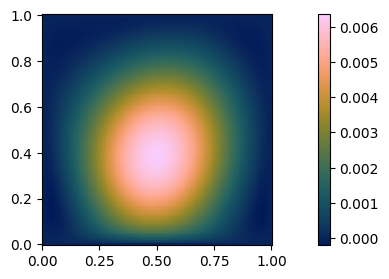

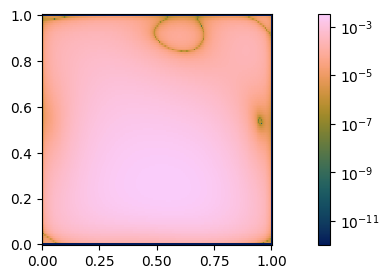

In [6]:
u_pred = model.predict(X, Y)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, Y, u_pred, cmap=cmap)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, Y, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

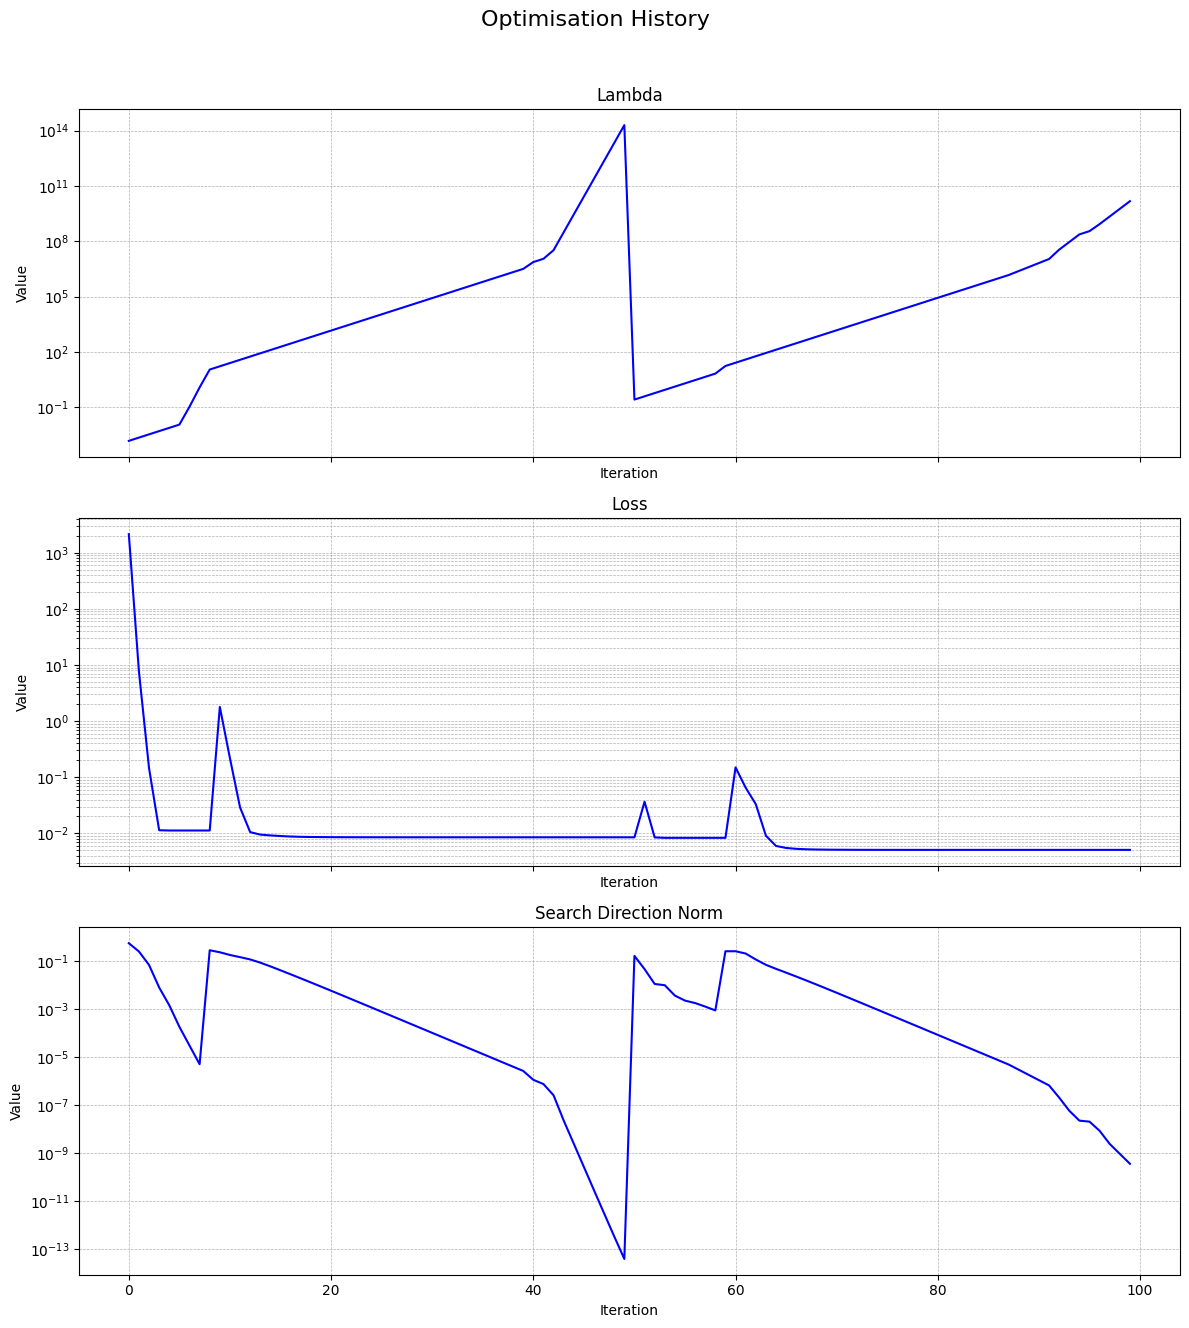

In [7]:
history.plot()